In [226]:
# from datetime import datetime
from IPython.display import display, Markdown
from datetime import datetime

todays_date = str(datetime.now().date())

display(Markdown("# Notebook - Visualize specificity prediction metrics"))
display(Markdown("Author: Lena Erlach"))
display(Markdown("Created: 2024-01-25"))
display(Markdown(f"Last modified: {todays_date}"))


import numpy as np
import pandas as pd
import os
import sys
import configparser

UTILS_DIR = "/data/cb/scratch/lenae/sc_AbSpecificity_pred/src"
sys.path.append(UTILS_DIR)
from itertools import chain
import matplotlib.pyplot as plt

CONFIG_PATH = "/data/cb/scratch/lenae/sc_AbSpecificity_pred/config_file_model_eval.txt"

import seaborn as sns

# Notebook - Visualize specificity prediction metrics

Author: Lena Erlach

Created: 2024-01-25

Last modified: 2024-08-27

In [227]:
### Custom functions

def metric_plot(metrics_df, x="features", y="F1", hue="Model_split", figsize=(12, 5)):
    custom_params = {"axes.spines.right": False, "axes.spines.top": False}
    sns.set_theme(rc={"figure.figsize": figsize})
    sns.set_theme(style="ticks", rc=custom_params)
    # take paired color palette, but remove the 5th and 6th color (red) for colorblind-friendliness
    sns.set_palette(
        sns.color_palette("Paired")[0:4] + sns.color_palette("Paired")[6:10]
    )

    ax = sns.barplot(y=y, x=x, hue=hue, data=metrics_df)
    sns.move_legend(
        ax,
        "lower center",
        bbox_to_anchor=(0.5, 0.95),
        ncol=2,
        title=None,
        frameon=False,
    )
    ax.set_ylim(0, 1)
    ax.set_yticks(np.arange(0, 1.05, 0.1))

    conc2 = list(
        chain.from_iterable([[i] * 8 for i in range(int(len(metrics_df) / 8))])
    )

    width = 0.25
    # add = [-1.2 * width, -0.4 * width, 0.4 * width, 1.2 * width] * int(len(metrics_df) / 4)
    add = [
        -1.4 * width,
        -1.0 * width,
        -0.6 * width,
        -0.2 * width,
        0.2 * width,
        0.6 * width,
        1.0 * width,
        1.4 * width,
    ] * int(len(metrics_df) / 8)

    x_vals = np.array(conc2) + np.array(add)

    plt.errorbar(
        x=x_vals,
        y=metrics_df[y],
        yerr=metrics_df[f"{y}_std"],
        fmt="none",
        c="black",
        capsize=2,
    )

    plt.xlabel("")
    plt.xticks(rotation=35, ha="right")
    plt.tight_layout()
    plt.grid()
    return plt


def barplot_annotate_brackets(
    num1,
    num2,
    data,
    center,
    height,
    ax=None,
    yerr=None,
    dh=0.05,
    barh=0.05,
    fs=None,
    maxasterix=None,
):
    """
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """

    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ""
        p = 0.05

        while data < p:
            text += "*"
            p /= 10.0

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = "n. s."

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= ax_y1 - ax_y0
    barh *= ax_y1 - ax_y0

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y + barh, y + barh, y]
    mid = ((lx + rx) / 2, y + barh)

    if ax is not None:
        ax.plot(barx, bary, c="black")
    else:
        plt.plot(barx, bary, c="black")

    kwargs = dict(ha="center", va="bottom")
    if fs is not None:
        kwargs["fontsize"] = fs

    if ax is not None:
        ax.text(*mid, text, **kwargs)
    else:
        plt.text(*mid, text, **kwargs)


from scipy.stats import ttest_ind_from_stats
from statsmodels.stats.multitest import multipletests


def welch_t_test(sample_mean1, sample_std1, n1, sample_mean2, sample_std2, n2):
    t_statistic = ttest_ind_from_stats(
        sample_mean1, sample_std1, n1, sample_mean2, sample_std2, n2, equal_var=False
    )
    return t_statistic


def significance_comparison(metrics_df, indexing="all"):
    n = len(metrics_df)
    p_values = np.zeros((n, n))

    # Collect all p-values
    for i in range(n):
        for j in range(n):
            if i != j:
                t_statistic = welch_t_test(
                    metrics_df.loc[i, "F1"],
                    metrics_df.loc[i, "F1_std"],
                    5,
                    metrics_df.loc[j, "F1"],
                    metrics_df.loc[j, "F1_std"],
                    5,
                )
                p_values[i, j] = t_statistic.pvalue

    # Apply p-value correction (e.g., Benjamini-Hochberg, 'fdr_bh', Bonferronin, 'bonferroni)
    _, corrected_p_values, _, _ = multipletests(
        p_values.ravel(), alpha=0.05, method="bonferroni"
    )
    corrected_p_values = corrected_p_values.reshape(n, n)

    # Create an empty matrix to store the significance levels
    significance_matrix = np.empty((n, n), dtype=object)

    # Assign significance based on corrected p-values
    for i in range(n):
        for j in range(n):
            if i == j:
                significance_matrix[i, j] = ""
            else:
                p_value = corrected_p_values[i, j]
                if p_value < 0.05:
                    significance_matrix[i, j] = "*"
                    if p_value < 0.01:
                        significance_matrix[i, j] = "**"
                        if p_value < 0.001:
                            significance_matrix[i, j] = "***"
                else:
                    significance_matrix[i, j] = "n.s."

    # Convert the significance matrix into a dataframe for better visualization
    significance_df = pd.DataFrame(significance_matrix)

    if indexing == "all":
        # Get the model names and features for indexing
        model_names = metrics_df["Model"].tolist()
        features = metrics_df["features"].tolist()
        sim_splits = metrics_df["train_test_split"].tolist()

        # Concatenate model names, features, and sim splits as row and column names
        row_col_names = [
            f"{model}_{feature}_{sim_split}"
            for model, feature, sim_split in zip(model_names, features, sim_splits)
        ]
        significance_df.index = row_col_names
        significance_df.columns = row_col_names

    elif indexing in ["train_test_split", "features", "Model"]:
        # Get the model names and features for indexing
        sim_splits = metrics_df[indexing].tolist()

        # Concatenate model names, features, and sim splits as row and column names
        row_col_names = [f"{sim_split}" for sim_split in sim_splits]
        significance_df.index = row_col_names
        significance_df.columns = row_col_names

    return significance_df


##### Barplots with significance brackets
def significance_plots(
    significance_comp_ls, metrics_list, features_list, y, model_num=1, figsize=(10, 5), d=0.07, annotate = True
):
    num_comparisons = len(significance_comp_ls)
    custom_params = {"axes.spines.right": False, "axes.spines.top": False}
    sns.set_theme(rc={"figure.figsize": figsize})
    sns.set_theme(style="ticks", rc=custom_params)
    sns.set_palette("Paired")

    fig, ax = plt.subplots(1, num_comparisons, sharey=True)

    for i, (x, metrics) in enumerate(zip(features_list, metrics_list)):
        sns.barplot(ax=ax[i], y=y, x=x, data=metrics)

        conc2 = list(
            chain.from_iterable(
                [[i] * model_num for i in range(int(len(metrics) / model_num))]
            )
        )

        add = [0] * int(len(metrics) / model_num)

        x_vals = np.array(conc2) + np.array(add)

        ax[i].errorbar(
            x=x_vals,
            y=metrics[y],
            yerr=metrics[f"{y}_std"],
            fmt="none",
            c="black",
            capsize=2,
        )

        ax[i].set_xlabel("")
        ax[i].tick_params(axis="x", labelrotation=45)
        ax[i].set_ylim(0, 1)
        ax[i].set_title(x)

        # annotate with bars
        if annotate == True:
            p = 0.02
            for j in range(len(metrics)):
                for k in range(j + 1, len(metrics)):
                    if significance_comp_ls[i].iloc[j, k] != "n.s.":
                        barplot_annotate_brackets(
                            j,
                            k,
                            ax=ax[i],
                            data=significance_comp_ls[i].iloc[j, k],
                            center=[x for x in range(len(metrics))],
                            height=metrics["F1"],
                            dh=d + p,
                            barh=0.02,
                        )
                        p += 0.07

    plt.tight_layout()
    return fig, ax


from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches


def significance_heatmap(
    significance_df, plot_outPath, figsize=(15, 15), save_plot=False
):
    # Map your significance strings to numerical values
    category_to_int = {"": 0, "n.s.": 1, "*": 2, "**": 3, "***": 4}
    significance_num = significance_df.replace(category_to_int)

    # plot heat map for the significance levels
    plt.figure(figsize=figsize)
    # palette = sns.color_palette("Blues", 3)
    colors = [
        (1, 1, 1),
        (1, 1, 1),
        (0.875, 0.938, 0.968),
        (0.417, 0.681, 0.838),
        (0.027, 0.313, 0.609),
    ]
    cmap = ListedColormap(colors)

    ax = sns.heatmap(
        significance_num,
        fmt="s",
        cmap=cmap,
        cbar=False,
        linewidths=0.5,
        linecolor="black",
    )

    # adjust axis
    ax.xaxis.tick_top()  # Move the x-axis ticks to the top
    ax.xaxis.set_label_position("top")
    ax.set_xticklabels(
        ax.get_xticklabels(), rotation=45, fontsize=6, ha="left"
    )  # Here, `fontsize=8` sets the font size to 8
    ax.set_yticklabels(
        ax.get_yticklabels(), rotation=0, fontsize=6
    )  # Here, `fontsize=8` sets the font size to 8

    # Create a list of patches for the legend
    legend_patches = [
        mpatches.Patch(facecolor=color, label=label, edgecolor="black")
        for label, color in zip(list(category_to_int.keys())[1:], colors[1:])
    ]
    # Add the legend to the plot
    plt.legend(
        handles=legend_patches,
        bbox_to_anchor=(1.05, 1),
        loc=2,
        borderaxespad=0.0,
        title="Significance Levels",
    )

    # adjust layout
    plt.tight_layout()

    # save plot
    if save_plot:
        plt.savefig(plot_outPath, dpi=600)

    plt.show()
    return plt

#### Config parser

In [228]:
# setup parser for the config file
config = configparser.ConfigParser()
config.read(CONFIG_PATH)
ROOT_DIR = config["ROOT"]["ROOT_DIR"]

plot_outPath = os.path.join(ROOT_DIR, config["PATHS"]["PLOT_OUT"])
if not os.path.exists(plot_outPath):
    os.makedirs(plot_outPath)

save_plots = True

## 1. VH_VL predictions

In [229]:
# Load the metric tables and prepare for plotting
split_ds = "EVAL_05SPLIT"


metrics = pd.DataFrame()
metrics_ls = []
# d = 'OVA'
for d in ["OVA", "OVA_ESM3", "RBD", "RBD_ESM3"]:
    datasets = [f"BCR_{d}_VH_VL"]
    metrics = pd.DataFrame()
    for datas in datasets:
        inpath = os.path.join(config[split_ds][datas])
        metrics_raw = pd.read_csv(inpath)
        metrics = pd.concat([metrics, metrics_raw])

    metrics_df = metrics.copy()
    metrics_df.Model = metrics_df.Model.str.strip("_")

    # split the model into features
    metrics_df["features"] = [f"{i[1]} \n{d}" for i in metrics_df.Model.str.split("_")]
    metrics_df["Model"] = [i[0] for i in metrics_df.Model.str.split("_")]

    # add split info to Model
    metrics_df.loc[
        metrics_df["train_test_split"] == "levenshtein_sequence_based",
        "train_test_split",
    ] = "sim_split"
    metrics_df["Model_split"] = [
        f"{m} {t}" for m, t in zip(metrics_df["Model"], metrics_df["train_test_split"])
    ]


    # drop the entries from the augmented models
    metrics_df = metrics_df[~metrics_df.features.str.contains("augmented")]
    # drop entries form 2-mer
    metrics_df = metrics_df[~metrics_df["features"].str.contains("2-mer")].reset_index(drop=True)

   
    # replace ESM3
    metrics_df["features"] = metrics_df["features"].str.replace("_ESM3", "")
    metrics_df.reset_index(drop=True, inplace=True)    
    

    metrics_ls.append(metrics_df)


metrics_df = pd.concat(metrics_ls, axis=0)
metrics_df.reset_index(drop=True, inplace=True)


feature_order = [
        f"ESM-2 \nOVA",
        f"ESM-2-CDRextract \nOVA",
         f"ESM-3 \nOVA",
        f"Antiberty \nOVA",
        f"3-mer \nOVA",
        f"ESM-2 \nRBD",
        f"ESM-2-CDRextract \nRBD",
         f"ESM-3 \nRBD",
        f"Antiberty \nRBD",
        f"3-mer \nRBD",
    ]
model_order = [
    "LogReg sim_split",
    "LogReg random_split",
    "kSVC sim_split",
    "kSVC random_split",
    "RF sim_split",
    "RF random_split",
    "GBoost sim_split",
    "GBoost random_split",
]

# Convert 'features' and 'Model_split' to categorical with the specified order
metrics_df["features"] = pd.Categorical(
    metrics_df["features"], categories=feature_order, ordered=True
)
metrics_df["Model_split"] = pd.Categorical(
    metrics_df["Model_split"], categories=model_order, ordered=True
)
metrics_df = metrics_df.sort_values(by=["features", "Model_split"])
metrics_df.reset_index(drop=True, inplace=True)

metrics_df["features"] = metrics_df["features"].astype(str)
metrics_df_VDJ = metrics_df.copy()

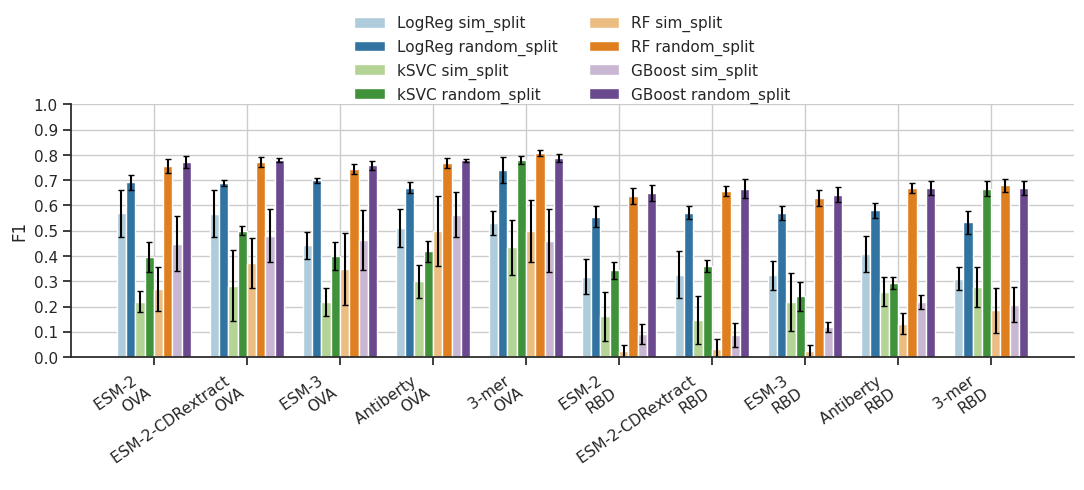

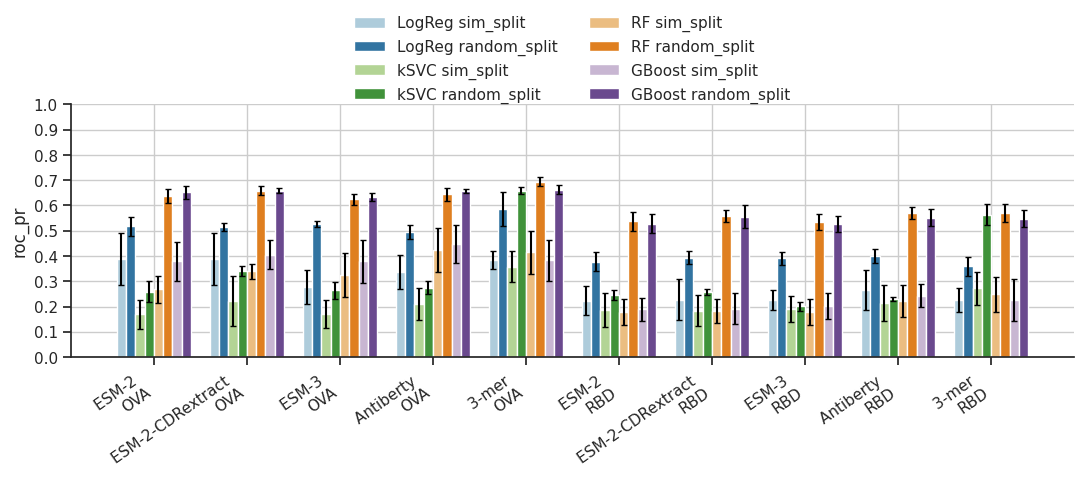

In [230]:
# create plots
for m in ["F1", "roc_pr"]:
    plt = metric_plot(metrics_df, x="features", y=m, hue="Model_split", figsize=(11, 5))

    if save_plots:
        plt.savefig(
            os.path.join(plot_outPath, f'{m}_BCR_VH_VL_metrics_Barplot.png'), dpi=600
        )

    plt.show()

### Significance test  
#### Test random vs similarity split

In [231]:
# aggregate means for sim_split and random_split
metrics_df["F1_variances"] = metrics_df.F1_std**2
metrics_df_agg = (
    metrics_df.groupby(["train_test_split"])
    .agg({"F1": "mean", "F1_variances": "mean"})
    .reset_index()
)
metrics_df_agg["F1_std"] = np.sqrt(metrics_df_agg.F1_variances)

# aggregate for antiberty, 3mer and ESM
metrics_df_OVA = metrics_df[metrics_df.features.str.contains("OVA")]
metrics_df_agg2 = (
    metrics_df_OVA.groupby(["features"])
    .agg({"F1": "mean", "F1_variances": "mean"})
    .reset_index()
)
metrics_df_agg2["F1_std"] = np.sqrt(metrics_df_agg2.F1_variances)
metrics_df_agg2

# aggregate for antiberty, 3mer and ESM
metrics_df_RBD = metrics_df[metrics_df.features.str.contains("RBD")]
metrics_df_agg3 = (
    metrics_df_RBD.groupby(["features"])
    .agg({"F1": "mean", "F1_variances": "mean"})
    .reset_index()
)
metrics_df_agg3["F1_std"] = np.sqrt(metrics_df_agg3.F1_variances)
# metrics_df_agg3


order1 = ["ESM-2 \nOVA", "ESM-2-CDRextract \nOVA", "ESM-3 \nOVA", "Antiberty \nOVA", "3-mer \nOVA"]
order2 = ["ESM-2 \nRBD", "ESM-2-CDRextract \nRBD", "ESM-3 \nRBD", "Antiberty \nRBD", "3-mer \nRBD"]
# Convert 'features' and 'Model_split' to categorical with the specified order
metrics_df_agg2["features"] = pd.Categorical(
    metrics_df_agg2["features"], categories=order1, ordered=True
)
metrics_df_agg3["features"] = pd.Categorical(
    metrics_df_agg3["features"], categories=order2, ordered=True
)
# Sort the DataFrame by 'features' first, then by 'Model_split'
metrics_df_agg2 = metrics_df_agg2.sort_values(by=["features"]).reset_index(drop=True)
metrics_df_agg3 = metrics_df_agg3.sort_values(by=["features"]).reset_index(drop=True)

# Test significance and create significance matrices
significance_df = significance_comparison(metrics_df_agg, indexing="train_test_split")
significance_df2 = significance_comparison(metrics_df_agg2, indexing="features")
significance_df3 = significance_comparison(metrics_df_agg3, indexing="features")

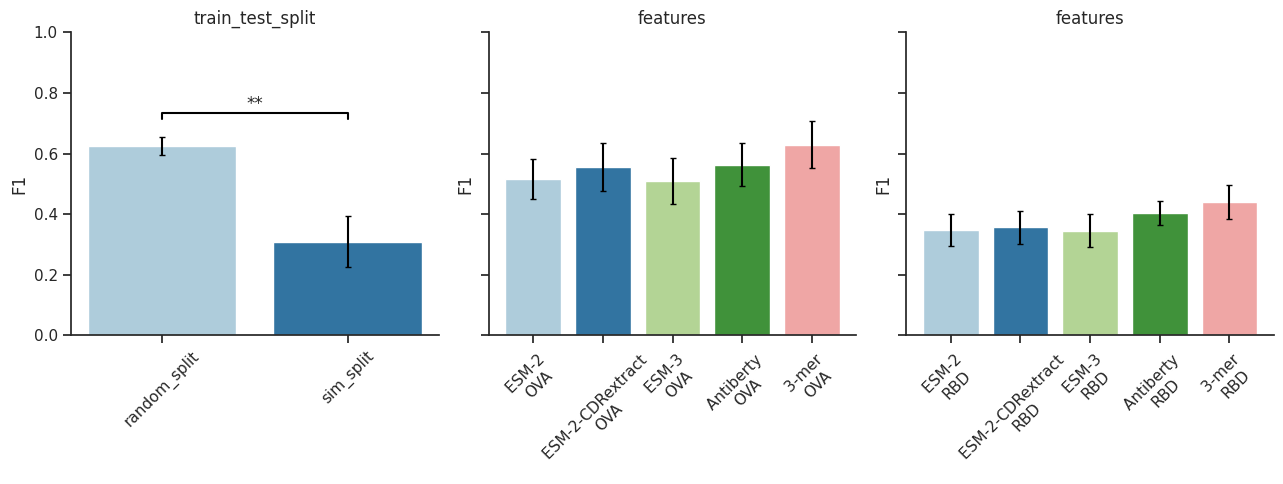

In [232]:
figsize = (13, 5)
y = "F1"
model_num = 1
significance_comp_ls = [significance_df, significance_df2, significance_df3]
metrics_list = [metrics_df_agg, metrics_df_agg2, metrics_df_agg3]
features_list = ["train_test_split", "features", "features"]


fig, ax = significance_plots(
    significance_comp_ls, metrics_list, features_list, y, model_num, figsize
)
# for i in range(3):
#     ax[i].set_yticks(np.arange(0, 1.05, 0.1))
#     ax[i].grid()


if save_plots:
    fig.savefig(
        os.path.join(plot_outPath, "split_feats_VH_VL_Barplot_sign.png"), dpi=600
    )

### Significance test  
#### models within OVA/RBD

In [233]:
# aggregate means for model type
metrics_df_agg2 = (
    metrics_df_OVA.groupby(["Model"])
    .agg({"F1": "mean", "F1_variances": "mean"})
    .reset_index()
)
metrics_df_agg2["F1_std"] = np.sqrt(metrics_df_agg2.F1_variances)

order = ["LogReg", "kSVC", "RF", "GBoost"]

# Convert 'features' and 'Model_split' to categorical with the specified order
metrics_df_agg2["Model"] = pd.Categorical(
    metrics_df_agg2["Model"], categories=order, ordered=True
)

# Sort the DataFrame by 'features' first, then by 'Model_split'
metrics_df_agg2 = metrics_df_agg2.sort_values(by=["Model"]).reset_index(drop=True)


# aggregate for antiberty, 3mer and ESM
metrics_df_agg3 = (
    metrics_df_RBD.groupby(["Model"])
    .agg({"F1": "mean", "F1_variances": "mean"})
    .reset_index()
)
metrics_df_agg3["F1_std"] = np.sqrt(metrics_df_agg3.F1_variances)
# Convert 'features' and 'Model_split' to categorical with the specified order
metrics_df_agg3["Model"] = pd.Categorical(
    metrics_df_agg3["Model"], categories=order, ordered=True
)

# Sort the DataFrame by 'features' first, then by 'Model_split'
metrics_df_agg3 = metrics_df_agg3.sort_values(by=["Model"]).reset_index(drop=True)

# Calculate significance
significance_df2 = significance_comparison(metrics_df_agg2, indexing="Model")
significance_df3 = significance_comparison(metrics_df_agg3, indexing="Model")

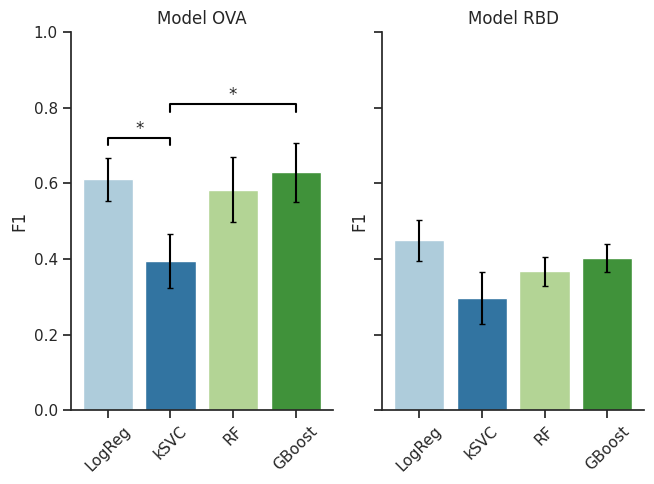

In [234]:
# plt = metric_plot_sig(metrics_df = metrics_df_agg, x='train_test_split', y='F1', hue='train_test_split', figsize=(8,5))
figsize = (6.7, 5)
y = "F1"
model_num = 1
significance_comp_ls = [significance_df2, significance_df3]
metrics_list = [metrics_df_agg2, metrics_df_agg3]
features_list = ["Model", "Model"]


# create barplot
fig, ax = significance_plots(
    significance_comp_ls, metrics_list, features_list, y, model_num, figsize
)

# rename subplots
fig.get_axes()[0].set_title("Model OVA")
fig.get_axes()[1].set_title("Model RBD")

# for i in range(2):
#     ax[i].grid()


if save_plots:
    fig.savefig(os.path.join(plot_outPath, "Model_VH_VL_Barplot_sign.png"), dpi=600)

### k-mer analysis - OVA

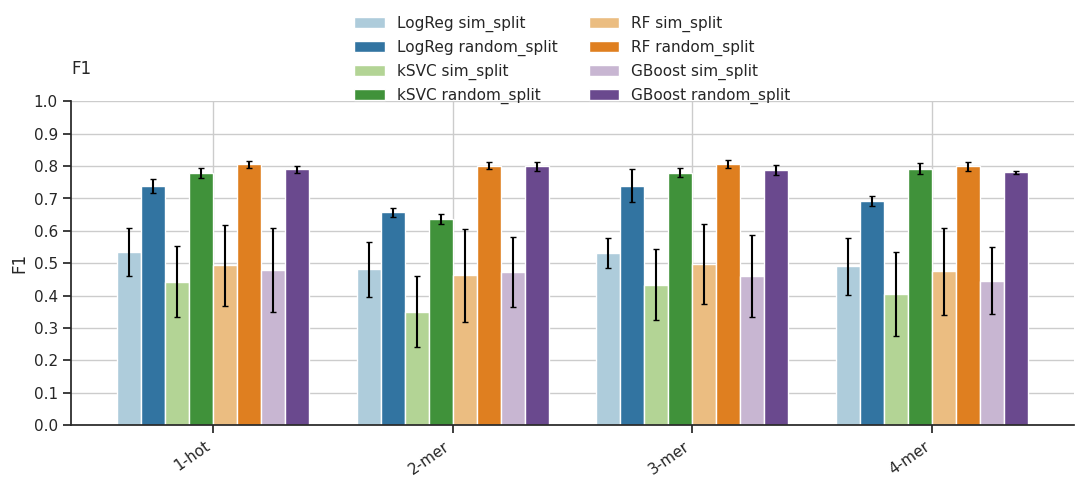

In [235]:
# Load OVA dataframe
split_ds = "EVAL_05SPLIT"

d = "BCR_OVA_1hot_VH_VL"

# Load dataset
inpath = os.path.join(ROOT_DIR, config[split_ds][d])
metrics_df = pd.read_csv(inpath)

# split models
metrics_df.Model = metrics_df.Model.str.strip("_")

# split the model into features
metrics_df["features"] = [i[1] for i in metrics_df.Model.str.split("_")]
metrics_df["Model"] = [i[0] for i in metrics_df.Model.str.split("_")]

# add split info to Model
metrics_df.loc[
    metrics_df["train_test_split"] == "levenshtein_sequence_based", "train_test_split"
] = "sim_split"
metrics_df["Model_split"] = [
    f"{m} {t}" for m, t in zip(metrics_df["Model"], metrics_df["train_test_split"])
]


model_order = [
    "LogReg sim_split",
    "LogReg random_split",
    "kSVC sim_split",
    "kSVC random_split",
    "RF sim_split",
    "RF random_split",
    "GBoost sim_split",
    "GBoost random_split",
]

# Convert 'features' and 'Model_split' to categorical with the specified order
metrics_df["Model_split"] = pd.Categorical(
    metrics_df["Model_split"], categories=model_order, ordered=True
)

# Sort the DataFrame by 'features' first, then by 'Model_split'
metrics_df = metrics_df.sort_values(by=["features", "Model_split"])
metrics_df.reset_index(drop=True, inplace=True)

# make barplot
for m in ["F1"]:
    plt = metric_plot(metrics_df, x="features", y=m, hue="Model_split", figsize=(11, 5))
    plt.title(m, loc="left", pad=20)
    # plt.grid()
    if save_plots:
        plt.savefig(
            os.path.join(plot_outPath, f"Review_BCR_OVA_1hot_kmer_{m}_Barplot.png"),
            dpi=600,
        )
    plt.show()

### Significance test  
#### Random vs sim split

In [236]:
# aggregate means for sim_split and random_split
metrics_df["F1_variances"] = metrics_df.F1_std**2
metrics_df_agg = (
    metrics_df.groupby(["train_test_split"])
    .agg({"F1": "mean", "F1_variances": "mean"})
    .reset_index()
)
metrics_df_agg["F1_std"] = np.sqrt(metrics_df_agg.F1_variances)

# compare features
metrics_df_agg1 = (
    metrics_df.groupby(["features"])
    .agg({"F1": "mean", "F1_variances": "mean"})
    .reset_index()
)
metrics_df_agg1["F1_std"] = np.sqrt(metrics_df_agg1.F1_variances)

# compare features by split of random and sim split
metrics_df_r = metrics_df[metrics_df["train_test_split"] == "random_split"]
metrics_df_s = metrics_df[metrics_df["train_test_split"] == "random_split"]

# aggregate metrics
metrics_df_agg2 = (
    metrics_df_r.groupby(["features"])
    .agg({"F1": "mean", "F1_variances": "mean"})
    .reset_index()
)
metrics_df_agg2["F1_std"] = np.sqrt(metrics_df_agg2.F1_variances)
metrics_df_agg3 = (
    metrics_df_s.groupby(["features"])
    .agg({"F1": "mean", "F1_variances": "mean"})
    .reset_index()
)
metrics_df_agg3["F1_std"] = np.sqrt(metrics_df_agg3.F1_variances)


# Test significance and create significance matrices
significance_df = significance_comparison(metrics_df_agg, indexing="train_test_split")
significance_df1 = significance_comparison(metrics_df_agg1, indexing="features")
significance_df2 = significance_comparison(metrics_df_agg2, indexing="features")
significance_df3 = significance_comparison(metrics_df_agg3, indexing="features")

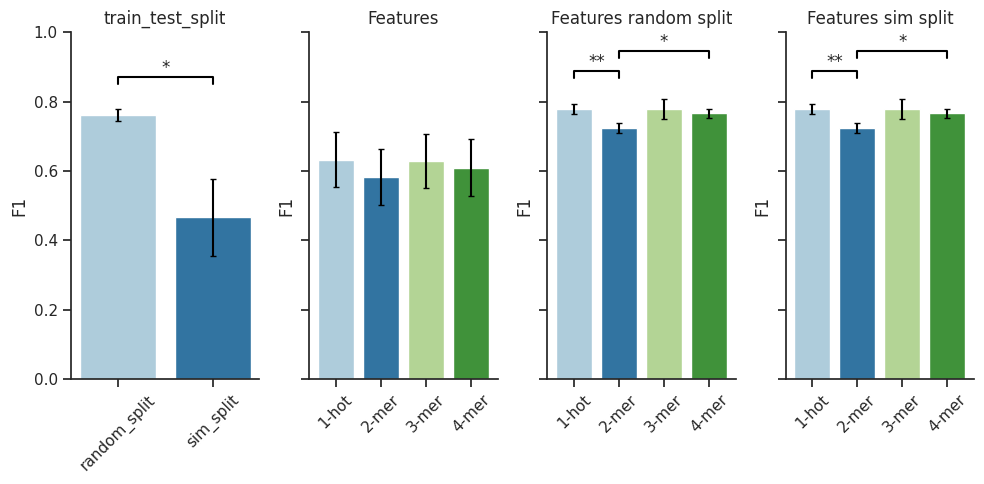

In [237]:
# make barplots with significance brackets
significance_comp_ls = [
    significance_df,
    significance_df1,
    significance_df2,
    significance_df3,
]
metrics_list = [metrics_df_agg, metrics_df_agg1, metrics_df_agg2, metrics_df_agg3]
features_list = ["train_test_split", "features", "features", "features"]


# create barplot
fig, ax = significance_plots(
    significance_comp_ls,
    metrics_list,
    features_list,
    y="F1",
    model_num=1,
    figsize=(10, 5),
)

# rename subplots
fig.get_axes()[1].set_title("Features")
fig.get_axes()[2].set_title("Features random split")
fig.get_axes()[3].set_title("Features sim split")
# for i in range(4):
#     ax[i].grid()

plt.show()

if save_plots:
    fig.savefig(os.path.join(plot_outPath, "Review_1hot_OVA_Barplot_sign.png"), dpi=600)

## 2. GEX predictions

In [238]:
# Load the metric tables and prepare for plotting
split_ds = "EVAL_05SPLIT"


metrics_ls = []

for d in ["OVA", "RBD", "INTEGRATED"]:
    # d = 'OVA'
    datasets = [f"GEX_BCR_{d}"]
    metrics = pd.DataFrame()
    for datas in datasets:
        inpath = os.path.join(ROOT_DIR, config[split_ds][datas])
        metrics_raw = pd.read_csv(inpath)[:24]
        metrics = pd.concat([metrics, metrics_raw])

    metrics_df = metrics.copy()
    # drop columns containing 'pca'
    metrics_df = metrics_df[~metrics_df["Model"].str.contains("pca")]
    metrics_df.Model = metrics_df.Model.str.strip("_")

    # split the model into features
    metrics_df["features"] = [
        f'{"_".join(i[1:])} \n{d}' for i in metrics_df.Model.str.split("_")
    ]
    metrics_df["Model"] = [i[0] for i in metrics_df.Model.str.split("_")]

    # add split info to Model
    metrics_df.loc[
        metrics_df["train_test_split"] == "levenshtein_sequence_based",
        "train_test_split",
    ] = "sim_split"
    metrics_df.loc[
        metrics_df["features"] == f"GEX_2000_var_3-mer \n{d}", "features"
    ] = f"GEX_2000_var_3-mer \n{d}"
    metrics_df["Model_split"] = [
        f"{m} {t}" for m, t in zip(metrics_df["Model"], metrics_df["train_test_split"])
    ]

    feature_order = [f"GEX_2000_var \n{d}", f"3-mer \n{d}", f"GEX_2000_var_3-mer \n{d}"]
    model_order = [
        "LogReg sim_split",
        "LogReg random_split",
        "kSVC sim_split",
        "kSVC random_split",
        "RF sim_split",
        "RF random_split",
        "GBoost sim_split",
        "GBoost random_split",
    ]

    # Convert 'features' and 'Model_split' to categorical with the specified order
    metrics_df["features"] = pd.Categorical(
        metrics_df["features"], categories=feature_order, ordered=True
    )
    metrics_df["Model_split"] = pd.Categorical(
        metrics_df["Model_split"], categories=model_order, ordered=True
    )

    # Sort the DataFrame by 'features' first, then by 'Model_split'
    metrics_df = metrics_df.sort_values(by=["features", "Model_split"])
    metrics_df.reset_index(drop=True, inplace=True)

    metrics_ls.append(metrics_df)


metrics_df = pd.concat(metrics_ls, axis=0)
metrics_df.reset_index(drop=True, inplace=True)

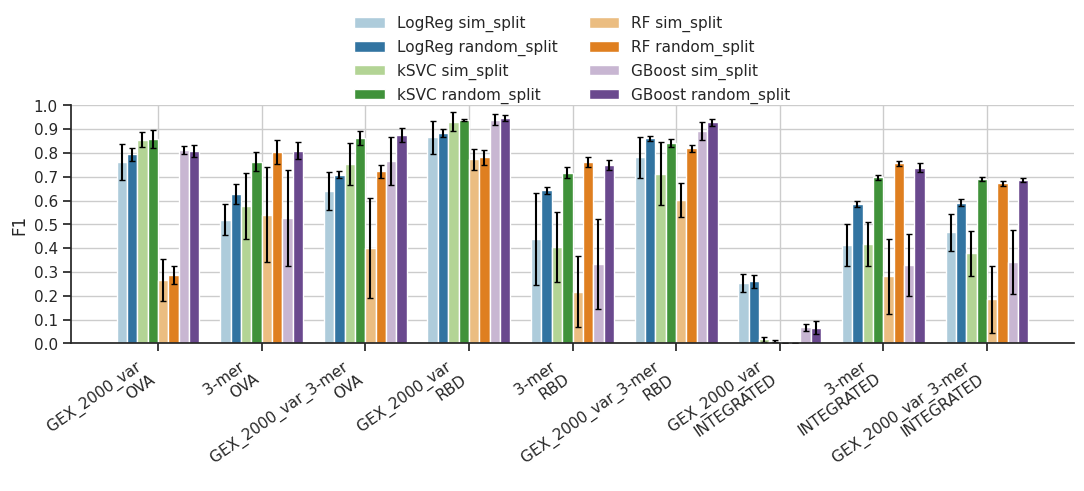

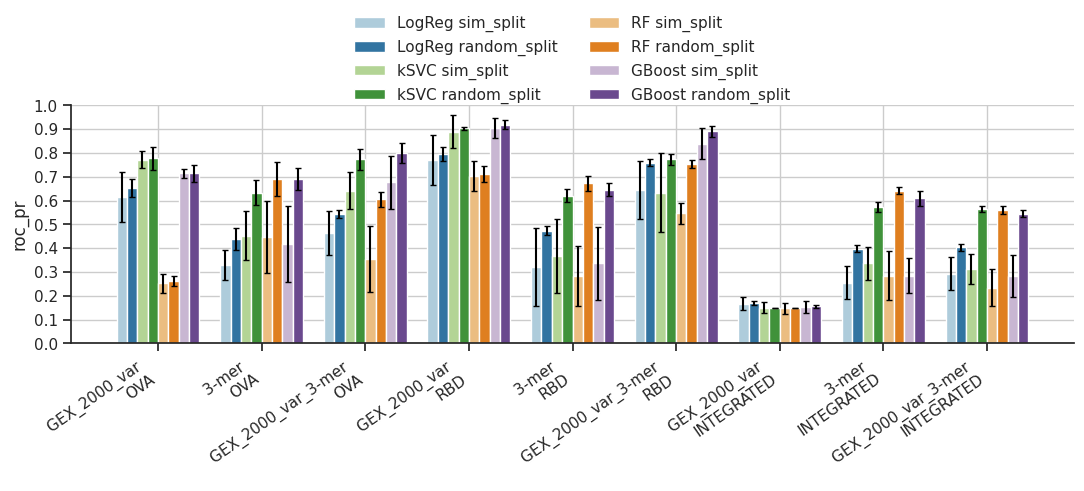

In [239]:
# create plots
for m in ["F1", "roc_pr"]:
    plt = metric_plot(metrics_df, x="features", y=m, hue="Model_split", figsize=(11, 5))

    if save_plots:
        plt.savefig(
            os.path.join(plot_outPath, f'{m}_GEX_BCR_metrics_Barplot.png'), dpi=600
        )
    plt.show()

### Create significance plots with GEX data

In [240]:
### Significance  analysis - random vs sim split
metrics_df["F1_variances"] = metrics_df.F1_std**2

# drop 3-mer features
metrics_df1 = metrics_df.copy()
metrics_df1 = metrics_df1[metrics_df1["features"] != "3-mer \nOVA"]
metrics_df1 = metrics_df1[metrics_df1["features"] != "3-mer \nRBD"]
metrics_df1 = metrics_df1[metrics_df1["features"] != "3-mer \nINTEGRATED"]
# aggregate means for sim_split and random_split
metrics_df_agg = (
    metrics_df1.groupby(["train_test_split"])
    .agg({"F1": "mean", "F1_variances": "mean"})
    .reset_index()
)
metrics_df_agg["F1_std"] = np.sqrt(metrics_df_agg.F1_variances)


# aggregate for antiberty, 3mer and ESM
# drop the entries from the augmented models
metrics_df_OVA = metrics_df[metrics_df.features.str.contains("OVA")]
metrics_df_agg2 = (
    metrics_df_OVA.groupby(["features"])
    .agg({"F1": "mean", "F1_variances": "mean"})
    .reset_index()
)
metrics_df_agg2["F1_std"] = np.sqrt(metrics_df_agg2.F1_variances)
metrics_df_agg2

# aggregate RBD
metrics_df_RBD = metrics_df[metrics_df.features.str.contains("RBD")]
metrics_df_agg3 = (
    metrics_df_RBD.groupby(["features"])
    .agg({"F1": "mean", "F1_variances": "mean"})
    .reset_index()
)
metrics_df_agg3["F1_std"] = np.sqrt(metrics_df_agg3.F1_variances)

# aggregate INT
metrics_df_INT = metrics_df[metrics_df.features.str.contains("INTEGRATED")]
metrics_df_agg4 = (
    metrics_df_INT.groupby(["features"])
    .agg({"F1": "mean", "F1_variances": "mean"})
    .reset_index()
)
metrics_df_agg4["F1_std"] = np.sqrt(metrics_df_agg4.F1_variances)


order1 = ["GEX_2000_var \nOVA", "GEX_2000_var_3-mer \nOVA", "3-mer \nOVA"]
order2 = ["GEX_2000_var \nRBD", "GEX_2000_var_3-mer \nRBD", "3-mer \nRBD"]
order3 = [
    "GEX_2000_var \nINTEGRATED",
    "GEX_2000_var_3-mer \nINTEGRATED",
    "3-mer \nINTEGRATED",
]
# Convert 'features' and 'Model_split' to categorical with the specified order
metrics_df_agg2["features"] = pd.Categorical(
    metrics_df_agg2["features"], categories=order1, ordered=True
)
metrics_df_agg3["features"] = pd.Categorical(
    metrics_df_agg3["features"], categories=order2, ordered=True
)
metrics_df_agg4["features"] = pd.Categorical(
    metrics_df_agg4["features"], categories=order3, ordered=True
)

# Sort the DataFrame by 'features' first, then by 'Model_split'
metrics_df_agg2 = metrics_df_agg2.sort_values(by=["features"]).reset_index(drop=True)
metrics_df_agg3 = metrics_df_agg3.sort_values(by=["features"]).reset_index(drop=True)
metrics_df_agg4 = metrics_df_agg4.sort_values(by=["features"]).reset_index(drop=True)


# Calculate significance
significance_df = significance_comparison(metrics_df_agg, indexing="train_test_split")
significance_df2 = significance_comparison(metrics_df_agg2, indexing="features")
significance_df3 = significance_comparison(metrics_df_agg3, indexing="features")
significance_df4 = significance_comparison(metrics_df_agg4, indexing="features")

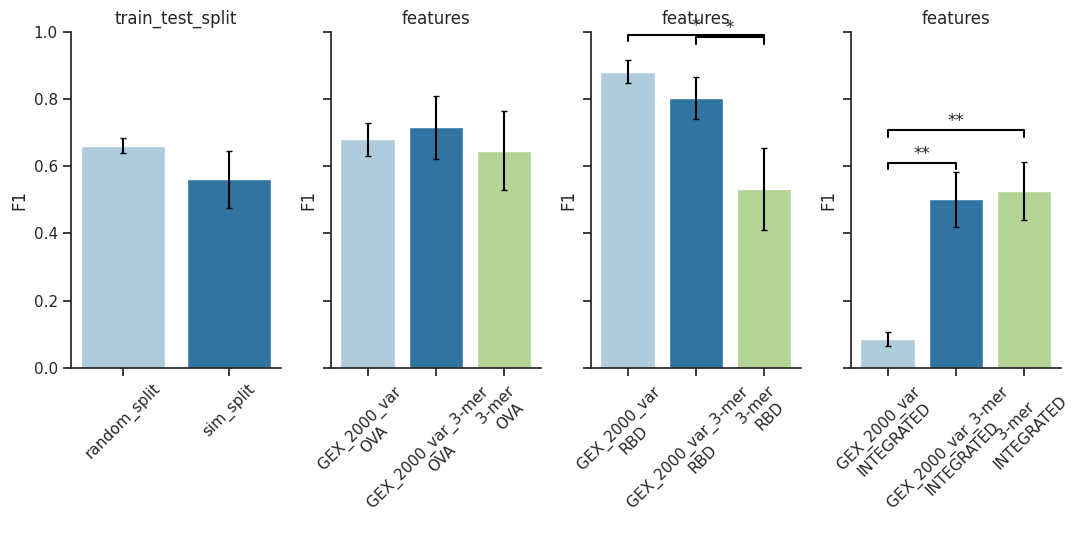

In [241]:
# plt = metric_plot_sig(metrics_df = metrics_df_agg, x='train_test_split', y='F1', hue='train_test_split', figsize=(8,5))
figsize = (11, 5.5)
y = "F1"
model_num = 1
significance_comp_ls = [
    significance_df,
    significance_df2,
    significance_df3,
    significance_df4,
]
metrics_list = [metrics_df_agg, metrics_df_agg2, metrics_df_agg3, metrics_df_agg4]
features_list = ["train_test_split", "features", "features", "features"]


# create barplot
fig, ax = significance_plots(
    significance_comp_ls, metrics_list, features_list, y, model_num, figsize
)

plt.show()
if save_plots:
    fig.savefig(os.path.join(plot_outPath, "split_feats_GEX_Barplot_sign.png"), dpi=600)

### Significance GEX - model type

In [74]:
order = ["LogReg", "kSVC", "RF", "GBoost"]

# aggregate means for model type
metrics_df_agg2 = (
    metrics_df_OVA.groupby(["Model"])
    .agg({"F1": "mean", "F1_variances": "mean"})
    .reset_index()
)
metrics_df_agg2["F1_std"] = np.sqrt(metrics_df_agg2.F1_variances)

# Sort the DataFrame by 'features' first, then by 'Model_split'
metrics_df_agg2["Model"] = pd.Categorical(
    metrics_df_agg2["Model"], categories=order, ordered=True
)
metrics_df_agg2 = metrics_df_agg2.sort_values(by=["Model"]).reset_index(drop=True)
# Convert 'features' and 'Model_split' to categorical with the specified order


# aggregate for antiberty, 3mer and ESM
metrics_df_agg3 = (
    metrics_df_RBD.groupby(["Model"])
    .agg({"F1": "mean", "F1_variances": "mean"})
    .reset_index()
)
metrics_df_agg3["F1_std"] = np.sqrt(metrics_df_agg3.F1_variances)

# Convert 'features' and 'Model_split' to categorical with the specified order
metrics_df_agg3["Model"] = pd.Categorical(
    metrics_df_agg3["Model"], categories=order, ordered=True
)
# Sort the DataFrame by 'features' first, then by 'Model_split'
metrics_df_agg3 = metrics_df_agg3.sort_values(by=["Model"]).reset_index(drop=True)


# aggregate for antiberty, 3mer and ESM
metrics_df_agg4 = (
    metrics_df_INT.groupby(["Model"])
    .agg({"F1": "mean", "F1_variances": "mean"})
    .reset_index()
)
metrics_df_agg4["F1_std"] = np.sqrt(metrics_df_agg4.F1_variances)

# Convert 'features' and 'Model_split' to categorical with the specified order
metrics_df_agg4["Model"] = pd.Categorical(
    metrics_df_agg4["Model"], categories=order, ordered=True
)
# Sort the DataFrame by 'features' first, then by 'Model_split'
metrics_df_agg4 = metrics_df_agg4.sort_values(by=["Model"]).reset_index(drop=True)


# Calculate significance
significance_df2 = significance_comparison(metrics_df_agg2, indexing="Model")
significance_df3 = significance_comparison(metrics_df_agg3, indexing="Model")
significance_df4 = significance_comparison(metrics_df_agg4, indexing="Model")

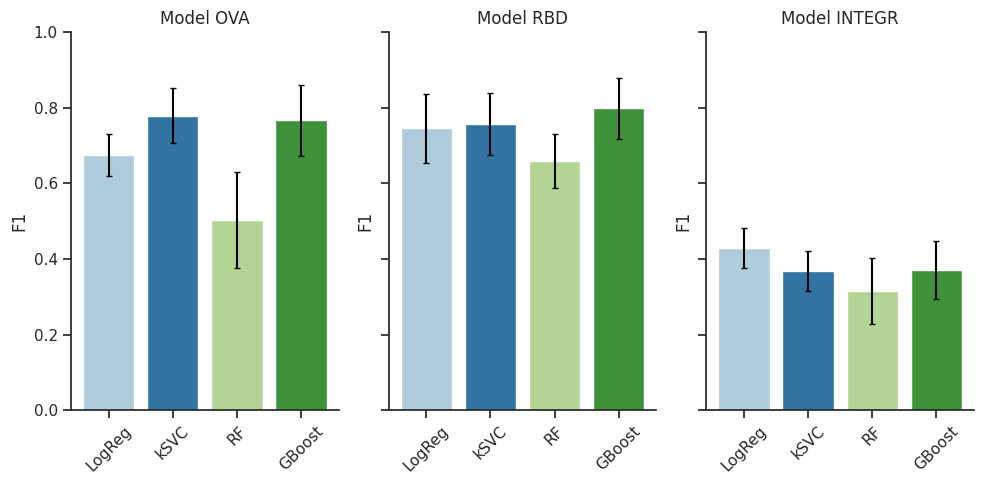

In [75]:
# plt = metric_plot_sig(metrics_df = metrics_df_agg, x='train_test_split', y='F1', hue='train_test_split', figsize=(8,5))
figsize = (10, 5)
y = "F1"
model_num = 1

significance_comp_ls = [significance_df2, significance_df3, significance_df4]
metrics_list = [metrics_df_agg2, metrics_df_agg3, metrics_df_agg4]
features_list = ["Model", "Model", "Model"]


# create barplot
fig, ax = significance_plots(
    significance_comp_ls, metrics_list, features_list, y, model_num, figsize
)
ax[0].set_title("Model OVA")
ax[1].set_title("Model RBD")
ax[2].set_title("Model INTEGR")
plt.show()

if save_plots:
    fig.savefig(os.path.join(plot_outPath, "Model_GEX_Barplot_sign.png"), dpi=600)

### Significance SUMMARY - model type with BCR data

In [242]:
# concat the metrics dfs 
metrics_df_comb = pd.concat([metrics_df_VDJ, metrics_df], axis=0)

# aggregate means for sim_split and random_split
metrics_df_comb["F1_variances"] = metrics_df_comb.F1_std**2
metrics_df_agg = (
    metrics_df_comb.groupby(["train_test_split"])
    .agg({"F1": "mean", "F1_variances": "mean"})
    .reset_index()
)
metrics_df_agg["F1_std"] = np.sqrt(metrics_df_agg.F1_variances)

# aggregate for antiberty, 3mer and ESM
metrics_df_OVA = metrics_df_comb[metrics_df_comb.features.str.contains("OVA")]
metrics_df_agg2 = (
    metrics_df_OVA.groupby(["features"])
    .agg({"F1": "mean", "F1_variances": "mean"})
    .reset_index()
)
metrics_df_agg2["F1_std"] = np.sqrt(metrics_df_agg2.F1_variances)
metrics_df_agg2

# aggregate for antiberty, 3mer and ESM
metrics_df_RBD = metrics_df_comb[metrics_df_comb.features.str.contains("RBD")]
metrics_df_agg3 = (
    metrics_df_RBD.groupby(["features"])
    .agg({"F1": "mean", "F1_variances": "mean"})
    .reset_index()
)
metrics_df_agg3["F1_std"] = np.sqrt(metrics_df_agg3.F1_variances)
# metrics_df_agg3


order1 = ["ESM-2 \nOVA", "ESM-2-CDRextract \nOVA", "ESM-3 \nOVA", "Antiberty \nOVA", "3-mer \nOVA", "GEX_2000_var \nOVA", "GEX_2000_var_3-mer \nOVA"]
order2 = ["ESM-2 \nRBD", "ESM-2-CDRextract \nRBD", "ESM-3 \nRBD", "Antiberty \nRBD", "3-mer \nRBD", "GEX_2000_var \nRBD", "GEX_2000_var_3-mer \nRBD"]
# Convert 'features' and 'Model_split' to categorical with the specified order
metrics_df_agg2["features"] = pd.Categorical(
    metrics_df_agg2["features"], categories=order1, ordered=True
)
metrics_df_agg3["features"] = pd.Categorical(
    metrics_df_agg3["features"], categories=order2, ordered=True
)
# Sort the DataFrame by 'features' first, then by 'Model_split'
metrics_df_agg2 = metrics_df_agg2.sort_values(by=["features"]).reset_index(drop=True)
metrics_df_agg3 = metrics_df_agg3.sort_values(by=["features"]).reset_index(drop=True)

# Test significance and create significance matrices
significance_df = significance_comparison(metrics_df_agg, indexing="train_test_split")
significance_df2 = significance_comparison(metrics_df_agg2, indexing="features")
significance_df3 = significance_comparison(metrics_df_agg3, indexing="features")

In [243]:
significance_df3 ### ---> manual annotation of significance plot

,ESM-2 \nRBD,ESM-2-CDRextract \nRBD,ESM-3 \nRBD,Antiberty \nRBD,3-mer \nRBD,GEX_2000_var \nRBD,GEX_2000_var_3-mer \nRBD
ESM-2 \nRBD,,n.s.,n.s.,n.s.,n.s.,***,***
ESM-2-CDRextract \nRBD,n.s.,,n.s.,n.s.,n.s.,***,***
ESM-3 \nRBD,n.s.,n.s.,,n.s.,n.s.,***,***
Antiberty \nRBD,n.s.,n.s.,n.s.,,n.s.,***,***
3-mer \nRBD,n.s.,n.s.,n.s.,n.s.,,*,*
GEX_2000_var \nRBD,***,***,***,***,*,,n.s.
GEX_2000_var_3-mer \nRBD,***,***,***,***,*,n.s.,


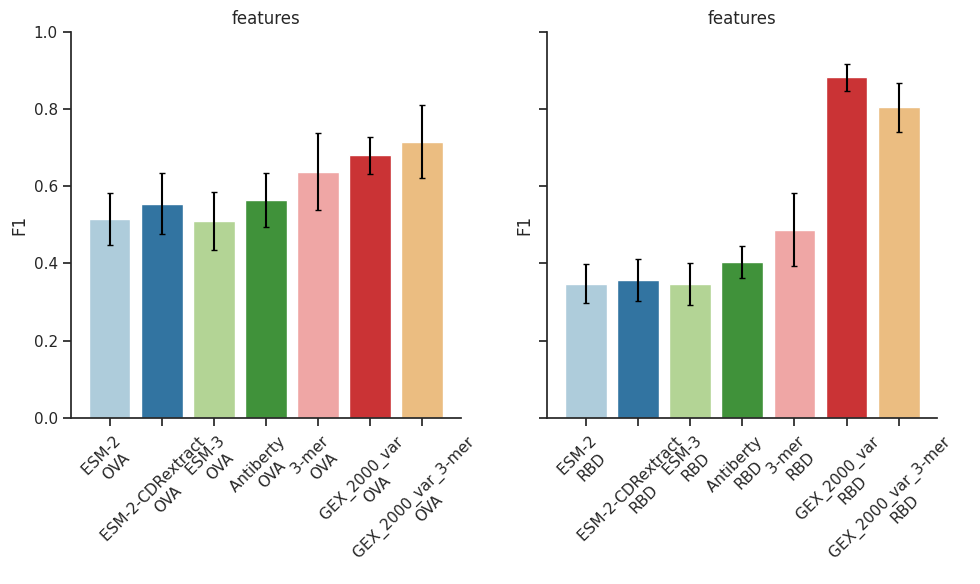

In [249]:
figsize = (10, 6)
y = "F1"
model_num = 1
significance_comp_ls = [significance_df2, significance_df3]
metrics_list = [metrics_df_agg2, metrics_df_agg3]
features_list = ["features", "features"]


fig, ax = significance_plots(
    significance_comp_ls, metrics_list, features_list, y, model_num=1, figsize=figsize, annotate = False
)

# for i in range(3):
#     ax[i].set_yticks(np.arange(0, 1.05, 0.1))
#     ax[i].grid()


if save_plots:
    fig.savefig(
        os.path.join(plot_outPath, "split_feats_comb_Barplot_sign.png"), dpi=600
    )